In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn import __version__ as sklearn_version
from sklearn.model_selection import cross_validate, GridSearchCV, learning_curve, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, LassoCV
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

import datetime

# 0. Import train and test data

In [2]:
X_train = pd.read_csv('../data/processed/X_train.csv', index_col='occupation')
y_train = pd.read_csv('../data/processed/y_train.csv', index_col='occupation')
X_test = pd.read_csv('../data/processed/X_test.csv', index_col='occupation')
y_test = pd.read_csv('../data/processed/y_test.csv', index_col='occupation')

In [3]:
X_train.shape, X_test.shape

((95228, 82), (40813, 82))

In [4]:
y_train.shape, y_test.shape

((95228, 1), (40813, 1))

# 1. Baseline Model

In [5]:
# Pipeline: Standardize and mean as the estimate
pipe_mean = make_pipeline(MinMaxScaler(), 
                         DummyRegressor(strategy='mean'))

## 1.a Cross-validate

In [6]:
# Cross-validate
cv_mean = cross_validate(pipe_mean, X_train, y_train, cv=5)

cv_mean_scores = cv_mean['test_score']
cv_mean_scores

array([-2.82847634e-06, -6.42477611e-05, -8.64583284e-05, -6.29658705e-05,
       -5.56993366e-05])

In [7]:
# Mean and standard deviation of cv scores
print('Mean CV score: {}\nStandard Deviation: {}'.format(round(np.mean(cv_mean_scores), 5), 
                                                         round(np.std(cv_mean_scores), 5)))

Mean CV score: -5e-05
Standard Deviation: 3e-05


In [8]:
# +- 2 standard deviations
np.round((np.mean(cv_mean_scores) - 2 * np.std(cv_mean_scores), np.mean(cv_mean_scores) + 2 * np.std(cv_mean_scores)), 1)

array([-0.,  0.])

In [9]:
# Fit time and scoring time
cv_mean_fit_time = cv_mean['fit_time']
cv_mean_score_time = cv_mean['score_time']

print('Fit time: {}\nScore time: {}'.format(round(cv_mean_fit_time.mean(), 4), round(cv_mean_score_time.mean(), 4)))

Fit time: 0.0682
Score time: 0.005


## 1.b Model performance

In [10]:
# Fit pipeline. Train and test predictions.
pipe_mean.fit(X_train, y_train)
y_tr_mean_pred = pipe_mean.predict(X_train)
y_te_mean_pred = pipe_mean.predict(X_test)

In [11]:
# R-squared error
print('R^2 train: {}\nR^2 test: {}'.format(r2_score(y_train, y_tr_mean_pred), r2_score(y_test, y_te_mean_pred)))

R^2 train: 0.0
R^2 test: -1.7130880713978058e-06


In [12]:
# Mean Squared Error (MAE)
print('MSE train: {}\nMSE test: {}'.format(round(mean_absolute_error(y_train, y_tr_mean_pred)),
                                           round( mean_absolute_error(y_test, y_te_mean_pred))))

MSE train: 24541
MSE test: 24323


In [13]:
# Mean absolute Error (MSE)
print('MAE train: {}\nMAE test: {}'.format(round(mean_squared_error(y_train, y_tr_mean_pred)), 
                                           round(mean_squared_error(y_test, y_te_mean_pred))))

MAE train: 1074915664
MAE test: 1054016657


# 2. Basic Linear Regression 

In [14]:
# Pipeline: Standardize, Linear Regression
pipe_lm = make_pipeline(MinMaxScaler(),
                       LinearRegression())

## 2.a Cross-validate

In [15]:
# Cross-validate
cv_lm = cross_validate(pipe_lm, X_train, y_train, cv=5)

cv_lm_scores = cv_lm['test_score']
cv_lm_scores

array([0.60365132, 0.60699329, 0.60608191, 0.60564679, 0.60923612])

In [16]:
# Mean and standard deviation of cv scores
print('Mean CV score: {}\nStandard Deviation: {}'.format(round(np.mean(cv_lm_scores), 5),
                                                         round(np.std(cv_lm_scores), 5)))

Mean CV score: 0.60632
Standard Deviation: 0.00182


In [17]:
# +- 2 standard deviations
np.round((np.mean(cv_lm_scores) - 2 * np.std(cv_lm_scores), np.mean(cv_lm_scores) + 2 * np.std(cv_lm_scores)), 2)

array([0.6 , 0.61])

In [18]:
# Fit time and scoring time
cv_lm_fit_time = cv_lm['fit_time']
cv_lm_score_time = cv_lm['score_time']

print('Fit time: {}\nScore time: {}'.format(round(cv_lm_fit_time.mean(), 4), round(cv_lm_score_time.mean(), 4)))

Fit time: 0.1315
Score time: 0.0057


## 2.b Model performance

In [19]:
# Fit pipeline. Train and test predictions.
pipe_lm.fit(X_train, y_train)
y_tr_lm_pred = pipe_lm.predict(X_train)
y_te_lm_pred = pipe_lm.predict(X_test)

In [20]:
# R_squared error
print('R^2 train: {}\nR^2 test: {}'.format(round(r2_score(y_train, y_tr_lm_pred), 3),
                                           round(r2_score(y_test, y_te_lm_pred), 3)))

R^2 train: 0.607
R^2 test: 0.604


In [21]:
# MAE of training data
print('MAE train: {}\nMSE test: {}'.format(round(mean_absolute_error(y_train, y_tr_lm_pred)), 
                                           round(mean_absolute_error(y_test, y_te_lm_pred))))

MAE train: 14257
MSE test: 14251


In [22]:
# MSE of training data
print('MSE train: {}\nMSE test: {}'.format(round(mean_squared_error(y_train, y_tr_lm_pred)), 
                                           round(mean_squared_error(y_test, y_te_lm_pred))))

MSE train: 422343367
MSE test: 417612243


# 3. Find best K and Linear Regression

In [23]:
# Pipeline: Standardize, Select best K, and Linear Regression
pipe_reg = make_pipeline(
    MinMaxScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

## 3.a Cross-validate

In [24]:
# Cross-validate
cv_reg = cross_validate(pipe_reg, X_train, y_train.values.ravel(), cv=5)

cv_reg_scores = cv_reg['test_score']
cv_reg_scores

array([0.50477401, 0.51306317, 0.51152779, 0.51006312, 0.50792524])

In [25]:
# Mean and standard deviation of cv scores
print('Mean CV score: {}\nStandard Deviation: {}'.format(round(np.mean(cv_reg_scores), 5), 
                                                         round(np.std(cv_reg_scores), 5)))

Mean CV score: 0.50947
Standard Deviation: 0.0029


In [26]:
# +- 2 standard deviations
np.round((np.mean(cv_reg_scores) - 2 * np.std(cv_reg_scores), np.mean(cv_reg_scores) + 2 * np.std(cv_reg_scores)), 2)

array([0.5 , 0.52])

In [27]:
# Fit time and scoring time
cv_reg_fit_time = cv_reg['fit_time']
cv_reg_score_time = cv_reg['score_time']

print('Fit time: {}\nScore time: {}'.format(round(cv_reg_fit_time.mean(), 4), round(cv_reg_score_time.mean(), 4)))

Fit time: 0.0816
Score time: 0.0047


## 3.b Hyperparameter search using GridSearchCV

In [28]:
# Grid for possible k's
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [29]:
# Grid search
reg_grid_cv = GridSearchCV(pipe_reg, param_grid=grid_params, cv=5, n_jobs=-1)
reg_grid_cv.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x7fb88ac2e670>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})

In [30]:
# Best k
score_mean = reg_grid_cv.cv_results_['mean_test_score']
score_std = reg_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in reg_grid_cv.cv_results_['param_selectkbest__k']]

reg_grid_cv.best_params_

{'selectkbest__k': 82}

In [31]:
# Cross-validate with best parameter
reg_best_cv_results = cross_validate(reg_grid_cv.best_estimator_, X_train, y_train.values.ravel(), cv=5)
reg_best_scores = reg_best_cv_results['test_score']
reg_best_scores

array([0.60365132, 0.60699329, 0.60608191, 0.60564679, 0.60923612])

In [32]:
# Mean and standard deviation of cv scores of model with best parameter
print('Mean CV score: {}\nStandard Deviation: {}'.format(round(np.mean(reg_best_scores), 5), 
                                                         round(np.std(reg_best_scores), 5)))

Mean CV score: 0.60632
Standard Deviation: 0.00182


In [33]:
# Fit time and scoring time
cv_reg_fit_time = reg_best_cv_results['fit_time']
cv_reg_score_time = reg_best_cv_results['score_time']

print('Fit time: {}\nScore time: {}'.format(round(cv_reg_fit_time.mean(), 4), round(cv_reg_score_time.mean(), 4)))

Fit time: 0.1841
Score time: 0.0115


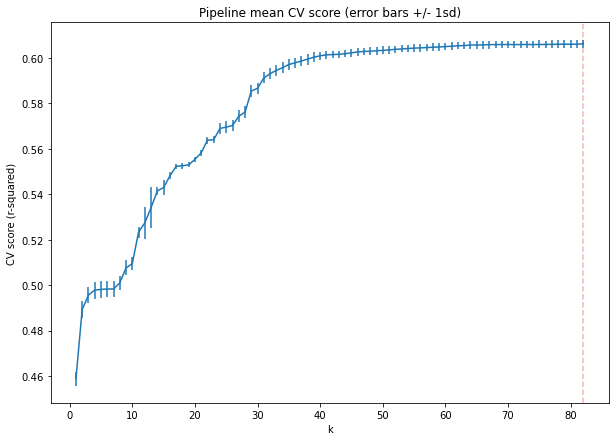

In [34]:
# Visualize selecting the best k
best_k = reg_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 7))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.3)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [35]:
# Most important features
coefs = reg_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns
most_important = pd.Series(coefs, index=features).sort_values(ascending=False)
most_important[:15]

Management of Financial Resources    54338.626480
Science                              41192.035716
Judgment and Decision Making         36809.624092
Persuasion                           35218.222749
Critical Thinking                    28431.693271
Active Learning                      22685.603616
Reading Comprehension                22369.108770
Management of Personnel Resources    21606.376076
Time Management                      19296.807846
Monitoring                           15198.278796
Systems Evaluation                   13761.458470
Speaking                             11095.404170
Complex Problem Solving               5710.209510
C_DC                                  4924.494524
C_CA                                  2872.364145
dtype: float64

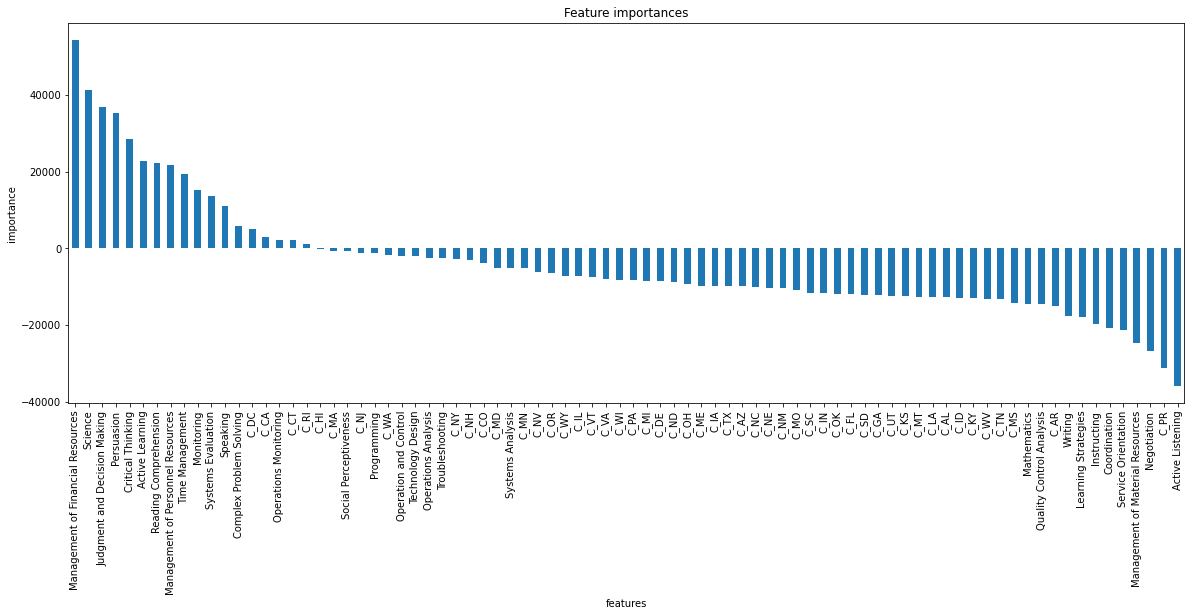

In [36]:
# Visualizing feature importance
plt.subplots(figsize=(20, 7))
most_important.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Feature importances');

In [37]:
# Pipeline: Standardize, Select best K with k=82, and Linear Regression
pipe_reg_82 = make_pipeline(
    MinMaxScaler(),
    SelectKBest(k=82),
    LinearRegression()
)

In [38]:
# Fit pipeline. Train and test predictions.
pipe_reg_82.fit(X_train, y_train.values.ravel())
y_tr_82_pred = pipe_reg_82.predict(X_train)
y_te_82_pred = pipe_reg_82.predict(X_test)

In [39]:
# R_squared error
print('R^2 train: {}\nR^2 test: {}'.format(round(r2_score(y_train, y_tr_82_pred), 3),
                                           round(r2_score(y_test, y_te_82_pred), 3)))

R^2 train: 0.607
R^2 test: 0.604


In [40]:
# MAE of training data
print('MAE train: {}\nMSE test: {}'.format(round(mean_absolute_error(y_train, y_tr_82_pred)), 
                                           round(mean_absolute_error(y_test, y_te_82_pred))))

MAE train: 14257
MSE test: 14251


# 4. Ridge Regression

In [41]:
# Pipeline: Normalize, Ridge Regression
pipe_ridge = make_pipeline(StandardScaler(),
                          Ridge())

## 4.a Cross-validate

In [42]:
# Cross-validate
cv_ridge = cross_validate(pipe_ridge, X_train, y_train.values.ravel(), cv=5)

cv_ridge_scores = cv_ridge['test_score']
cv_ridge_scores

array([0.60365086, 0.60699412, 0.60608314, 0.60564742, 0.60923439])

In [43]:
# Mean and standard deviation of cv scores
print('Mean CV score: {}\nStandard Deviation: {}'.format(round(np.mean(cv_ridge_scores), 5), 
                                                         round(np.std(cv_ridge_scores), 5)))

Mean CV score: 0.60632
Standard Deviation: 0.00182


In [44]:
# +- 2 standard deviations
np.round((np.mean(cv_ridge_scores) - 2 * np.std(cv_ridge_scores), np.mean(cv_ridge_scores) + 2 * np.std(cv_ridge_scores)), 2)

array([0.6 , 0.61])

In [45]:
# Fit time and scoring time
cv_ridge_fit_time = cv_ridge['fit_time']
cv_ridge_score_time = cv_ridge['score_time']

print('Fit time: {}\nScore time: {}'.format(round(cv_ridge_fit_time.mean(), 4), round(cv_ridge_score_time.mean(), 4)))

Fit time: 0.0736
Score time: 0.0047


## 4.b Hyperparameter search using GridSearchCV

In [46]:
# Grid for possible alpha's
alphas=np.logspace(-6, 6, 13)
grid_params = {'ridge__alpha': alphas}

In [47]:
# Grid search
ridge_grid_cv = GridSearchCV(pipe_ridge, param_grid=grid_params, cv=5, n_jobs=-1)
ridge_grid_cv.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'ridge__alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])})

In [48]:
# Best alpha
score_mean = ridge_grid_cv.cv_results_['mean_test_score']
score_std = ridge_grid_cv.cv_results_['std_test_score']
cv_alpha = [alpha for alpha in ridge_grid_cv.cv_results_['param_ridge__alpha']]

ridge_grid_cv.best_params_

{'ridge__alpha': 10.0}

In [49]:
# Cross-validate with best parameter
ridge_best_cv_results = cross_validate(ridge_grid_cv.best_estimator_, X_train, y_train.values.ravel(), cv=5)
ridge_best_scores = ridge_best_cv_results['test_score']
ridge_best_scores

array([0.6036466 , 0.60700122, 0.60609369, 0.60565255, 0.60921896])

In [50]:
# Mean and standard deviation of cv scores of model with best parameter
print('Mean CV score: {}\nStandard Deviation: {}'.format(round(np.mean(ridge_best_scores), 5), 
                                                         round(np.std(ridge_best_scores), 5)))

Mean CV score: 0.60632
Standard Deviation: 0.00182


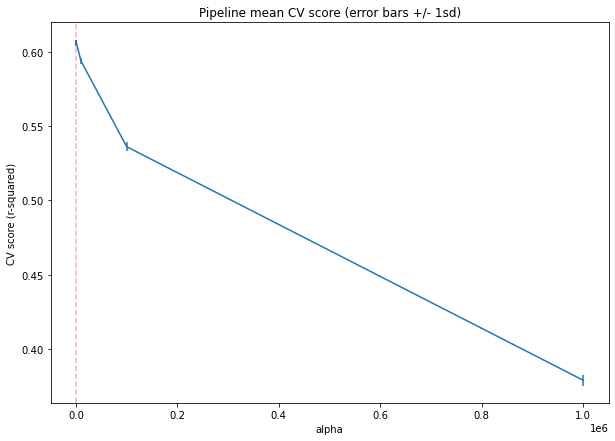

In [51]:
# Visualize selecting the best alpha
best_alpha = ridge_grid_cv.best_params_['ridge__alpha']
plt.subplots(figsize=(10, 7))
plt.errorbar(cv_alpha, score_mean, yerr=score_std)
plt.axvline(x=best_alpha, c='r', ls='--', alpha=.3)
plt.xlabel('alpha')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [52]:
# Most important features
coefs = ridge_grid_cv.best_estimator_.named_steps.ridge.coef_
features = X_train.columns
most_important = pd.Series(coefs, index=features).sort_values(ascending=False)
most_important[:15]

Management of Financial Resources    9257.736841
Science                              9105.958538
Persuasion                           6751.666478
Judgment and Decision Making         6647.733798
Active Learning                      4942.198916
Critical Thinking                    4822.555914
Reading Comprehension                3940.263759
Management of Personnel Resources    3556.424230
Time Management                      3393.064568
Monitoring                           2667.939789
Systems Evaluation                   2633.155713
Speaking                             1976.190587
Complex Problem Solving              1153.638386
C_CA                                  811.113810
Operations Monitoring                 416.262775
dtype: float64

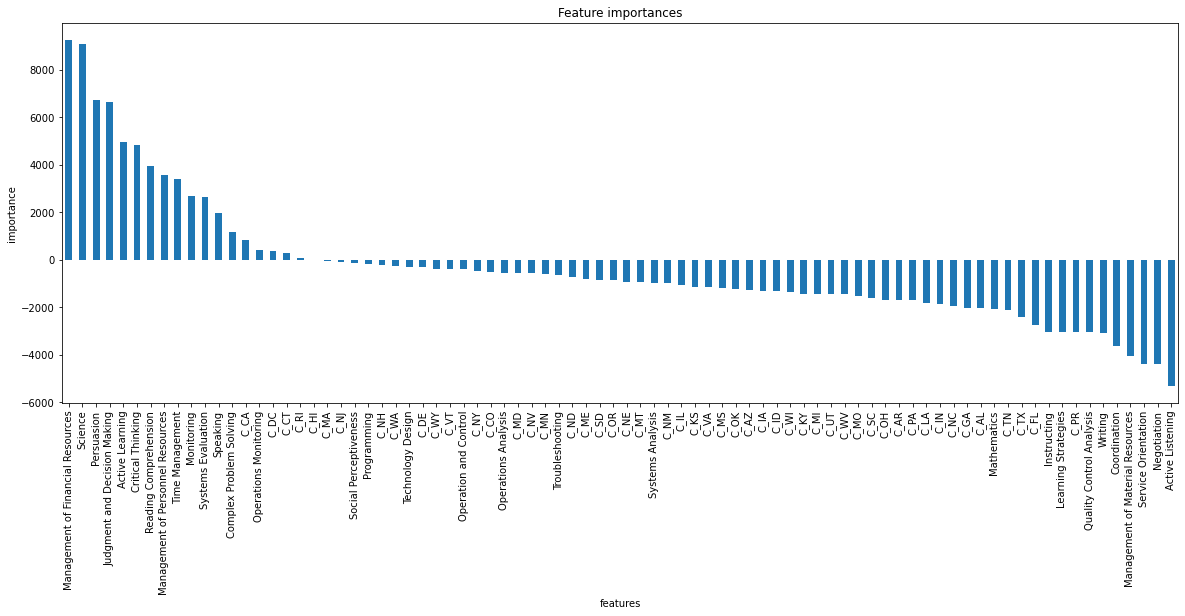

In [53]:
# Visualizing feature importance
plt.subplots(figsize=(20, 7))
most_important.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Feature importances');

In [54]:
# Pipeline: Normalize, Ridge Regression (alpha=10)
pipe_ridge10 = make_pipeline(StandardScaler(),
                          Ridge(alpha=10))

In [55]:
# Fit pipeline. Train and test predictions.
pipe_ridge10.fit(X_train, y_train.values.ravel())
y_tr_10_pred = pipe_ridge10.predict(X_train)
y_te_10_pred = pipe_ridge10.predict(X_test)

In [56]:
# R_squared error
print('R^2 train: {}\nR^2 test: {}'.format(round(r2_score(y_train, y_tr_10_pred), 3),
                                           round(r2_score(y_test, y_te_10_pred), 3)))

R^2 train: 0.607
R^2 test: 0.604


In [57]:
# MAE of training data
print('MAE train: {}\nMSE test: {}'.format(round(mean_absolute_error(y_train, y_tr_10_pred)), 
                                           round(mean_absolute_error(y_test, y_te_10_pred))))

MAE train: 14256
MSE test: 14250


# 5. Support Vector Regression

In [58]:
# Pipeline: Standardize, Linear Support Vector Regression
pipe_lsvr = make_pipeline(MinMaxScaler(),
                        svm.LinearSVR(max_iter=100000))

## 5.a Cross-validate

In [59]:
# Cross-validate
cv_lsvr = cross_validate(pipe_lsvr, X_train, y_train.values.ravel(), cv=5)

cv_lsvr_scores = cv_lsvr['test_score']
cv_lsvr_scores

array([0.37859212, 0.38745579, 0.38952578, 0.37744504, 0.38221104])

In [60]:
# Mean and standard deviation of cv scores
print('Mean CV score: {}\nStandard Deviation: {}'.format(round(np.mean(cv_lsvr_scores), 5), 
                                                         round(np.std(cv_lsvr_scores), 5)))

Mean CV score: 0.38305
Standard Deviation: 0.00476


In [61]:
# +- 2 standard deviations
np.round((np.mean(cv_lsvr_scores) - 2 * np.std(cv_lsvr_scores), np.mean(cv_lsvr_scores) + 2 * np.std(cv_lsvr_scores)), 2)

array([0.37, 0.39])

In [62]:
# Fit time and scoring time
cv_lsvr_fit_time = cv_lsvr['fit_time']
cv_lsvr_score_time = cv_lsvr['score_time']

print('Fit time: {}\nScore time: {}'.format(round(cv_lsvr_fit_time.mean(), 4), round(cv_lsvr_score_time.mean(), 4)))

Fit time: 0.1765
Score time: 0.0049


## 5.b Hyperparameter search using GridSearchCV

In [63]:
pipe_lsvr.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'minmaxscaler', 'linearsvr', 'minmaxscaler__clip', 'minmaxscaler__copy', 'minmaxscaler__feature_range', 'linearsvr__C', 'linearsvr__dual', 'linearsvr__epsilon', 'linearsvr__fit_intercept', 'linearsvr__intercept_scaling', 'linearsvr__loss', 'linearsvr__max_iter', 'linearsvr__random_state', 'linearsvr__tol', 'linearsvr__verbose'])

In [64]:
# Grids for epsilon and C
grid_params = {'linearsvr__C': np.logspace(-6, 6, 13), 'linearsvr__epsilon': np.logspace(-6, 6, 13)}

In [65]:
# Grid search
lsvr_grid_cv = GridSearchCV(pipe_lsvr, param_grid=grid_params, cv=5, n_jobs=-1)
lsvr_grid_cv.fit(X_train, y_train.values.ravel())

/Users/shaghayeghroshan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/shaghayeghroshan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/shaghayeghroshan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/shaghayeghroshan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/shaghayeghroshan/opt/anaconda3/lib/python3.9/site-pac

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('linearsvr',
                                        LinearSVR(max_iter=100000))]),
             n_jobs=-1,
             param_grid={'linearsvr__C': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06]),
                         'linearsvr__epsilon': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])})

In [66]:
# Best parameters

# C
score_mean_C = lsvr_grid_cv.cv_results_['mean_test_score']
score_std_C = lsvr_grid_cv.cv_results_['std_test_score']
cv_C = [c for c in lsvr_grid_cv.cv_results_['param_linearsvr__C']]

# epsilon
score_mean_epsilon = lsvr_grid_cv.cv_results_['mean_test_score']
score_std_epsilon = lsvr_grid_cv.cv_results_['std_test_score']
cv_epsilon = [epsilon for epsilon in lsvr_grid_cv.cv_results_['param_linearsvr__epsilon']]

lsvr_grid_cv.best_params_

{'linearsvr__C': 1000000.0, 'linearsvr__epsilon': 10000.0}

In [67]:
# Cross-validate with best parameter
lsvr_best_cv_results = cross_validate(lsvr_grid_cv.best_estimator_, X_train, y_train.values.ravel(), cv=5)
lsvr_best_scores = lsvr_best_cv_results['test_score']
lsvr_best_scores

array([0.58348156, 0.5895082 , 0.59025015, 0.58401102, 0.58820231])

In [68]:
# Mean and standard deviation of cv scores of model with best parameter
print('Mean CV score: {}\nStandard Deviation: {}'.format(round(np.mean(lsvr_best_scores), 5), 
                                                         round(np.std(lsvr_best_scores), 5)))

Mean CV score: 0.58709
Standard Deviation: 0.00281


In [69]:
# Fit time and scoring time
cv_lsvr_fit_time = lsvr_best_cv_results['fit_time']
cv_lsvr_score_time = lsvr_best_cv_results['score_time']

print('Fit time: {}\nScore time: {}'.format(round(cv_lsvr_fit_time.mean(), 4), round(cv_lsvr_score_time.mean(), 4)))

Fit time: 78.1262
Score time: 0.0084


In [70]:
# Most important features
coefs = lsvr_grid_cv.best_estimator_.named_steps.linearsvr.coef_
features = X_train.columns
most_important = pd.Series(coefs, index=features).sort_values(ascending=False)
most_important[:15]

Management of Financial Resources    44059.417794
Judgment and Decision Making         30587.630662
Science                              29098.619952
Reading Comprehension                24744.525145
Persuasion                           21635.071391
Critical Thinking                    21566.727888
Management of Personnel Resources    16676.086224
Speaking                             14776.320183
Systems Evaluation                   13525.419917
Active Learning                      13290.017957
Time Management                      13052.518188
Monitoring                            7845.884936
Programming                           5123.262153
C_DC                                  3703.552604
Technology Design                     3309.871884
dtype: float64

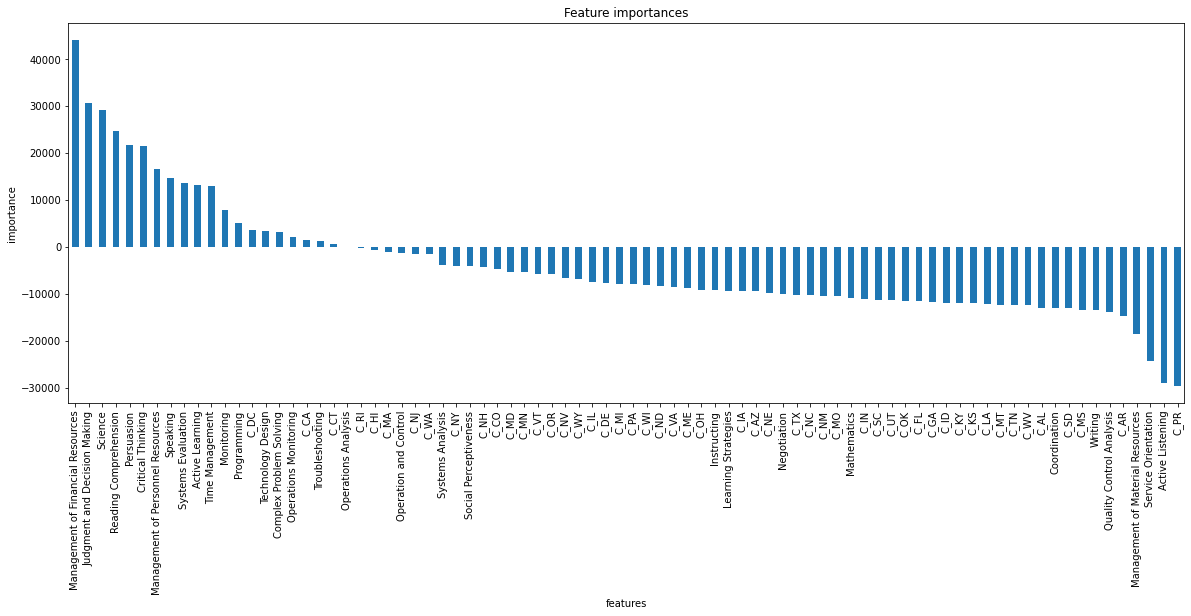

In [71]:
# Visualizing feature importance
plt.subplots(figsize=(20, 7))
most_important.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Feature importances');

In [72]:
# Pipeline: Standardize, Linear Support Vector Regression
pipe_lsvr0 = make_pipeline(MinMaxScaler(),
                        svm.LinearSVR(C=1000000, epsilon=10000, random_state=43, max_iter=100000))

In [73]:
# Fit pipeline. Train and test predictions.
pipe_lsvr0.fit(X_train, y_train.values.ravel())
y_tr_0_pred = pipe_lsvr0.predict(X_train)
y_te_0_pred = pipe_lsvr0.predict(X_test)

In [74]:
# R_squared error
print('R^2 train: {}\nR^2 test: {}'.format(round(r2_score(y_train, y_tr_0_pred), 3),
                                           round(r2_score(y_test, y_te_0_pred), 3)))

R^2 train: 0.587
R^2 test: 0.585


In [75]:
# MAE of training data
print('MAE train: {}\nMSE test: {}'.format(round(mean_absolute_error(y_train, y_tr_0_pred)), 
                                           round(mean_absolute_error(y_test, y_te_0_pred))))

MAE train: 13701
MSE test: 13671


# 6. NuSVR

In [76]:
# Pipeline: Standardize, NuSVR
pipe_nusvr = make_pipeline(MinMaxScaler(),
                        svm.NuSVR())

## 6.a Cross-validate

In [77]:
# Cross-validate
cv_nusvr = cross_validate(pipe_nusvr, X_train, y_train.values.ravel(), cv=5)

cv_nusvr_scores = cv_nusvr['test_score']
cv_nusvr_scores

array([0.0908866 , 0.09440623, 0.09532404, 0.08947235, 0.09047805])

In [78]:
# Mean and standard deviation of cv scores
print('Mean CV score: {}\nStandard Deviation: {}'.format(round(np.mean(cv_nusvr_scores), 5), 
                                                         round(np.std(cv_nusvr_scores), 5)))

Mean CV score: 0.09211
Standard Deviation: 0.00231


In [79]:
# +- 2 standard deviations
np.round((np.mean(cv_nusvr_scores) - 2 * np.std(cv_nusvr_scores), np.mean(cv_nusvr_scores) + 2 * np.std(cv_nusvr_scores)), 2)

array([0.09, 0.1 ])

In [80]:
# Fit time and scoring time
cv_nusvr_fit_time = cv_nusvr['fit_time']
cv_nusvr_score_time = cv_nusvr['score_time']

print('Fit time: {}\nScore time: {}'.format(round(cv_nusvr_fit_time.mean(), 4), round(cv_nusvr_score_time.mean(), 4)))

Fit time: 722.9083
Score time: 119.3734


# 7. Random Forest Model

In [81]:
# Pipeline: Standardize, Random Forest Model
pipe_rf = make_pipeline(
    MinMaxScaler(),
    RandomForestRegressor(random_state=42)
)

## 6.a Cross-validate

In [82]:
# Cross-validate
cv_rf = cross_validate(pipe_rf, X_train, y_train.values.ravel(), cv=5)

cv_rf_scores = cv_rf['test_score']
cv_rf_scores

array([0.88380804, 0.89273923, 0.88879779, 0.88759428, 0.88469459])

In [83]:
np.mean(cv_rf_scores), np.std(cv_rf_scores)

(0.8875267860497988, 0.0031824517006334503)

In [84]:
np.round((np.mean(cv_rf_scores) - 2 * np.std(cv_rf_scores), np.mean(cv_rf_scores) + 2 * np.std(cv_rf_scores)), 2)

array([0.88, 0.89])

In [85]:
# Fit time and scoring time
cv_rf_fit_time = cv_rf['fit_time']
cv_rf_score_time = cv_rf['score_time']

print('Fit time: {}\nScore time: {}'.format(round(cv_rf_fit_time.mean(), 4), round(cv_rf_score_time.mean(), 4)))

Fit time: 61.9533
Score time: 0.4297


## 7.b Hyperparameter search using GridSearchCV

In [86]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'minmaxscaler': [MinMaxScaler(), None]
}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'minmaxscaler': [MinMaxScaler(), None]}

In [98]:
rf_grid_cv = RandomizedSearchCV(pipe_rf, param_distributions=grid_params, cv=5, n_jobs=1, random_state=42)

In [99]:
rf_grid_cv.fit(X_train, y_train.values.ravel())

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                             ('randomforestregressor',
                                              RandomForestRegressor(random_state=42))]),
                   n_jobs=1,
                   param_distributions={'minmaxscaler': [MinMaxScaler(), None],
                                        'randomforestregressor__n_estimators': [10,
                                                                                12,
                                                                                16,
                                                                                20,
                                                                                26,
                                                                                33,
                                                                                42,
                                       

In [100]:
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 1000, 'minmaxscaler': MinMaxScaler()}

In [101]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train.values.ravel(), cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([0.88414225, 0.89288779, 0.88931372, 0.88775688, 0.88492679])

In [102]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(0.8878054864320493, 0.0031563618340609456)

In [103]:
coefs = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
features = X_train.columns
most_important = pd.Series(coefs, index=features).sort_values(ascending=False)
most_important[:15]

Complex Problem Solving              0.408462
Critical Thinking                    0.127571
Management of Financial Resources    0.049364
Science                              0.047979
Systems Analysis                     0.031733
Monitoring                           0.026065
Systems Evaluation                   0.020096
Operations Analysis                  0.018722
Social Perceptiveness                0.016030
C_CA                                 0.013652
Reading Comprehension                0.012827
Mathematics                          0.012788
Operations Monitoring                0.011543
Coordination                         0.010442
Service Orientation                  0.010439
dtype: float64

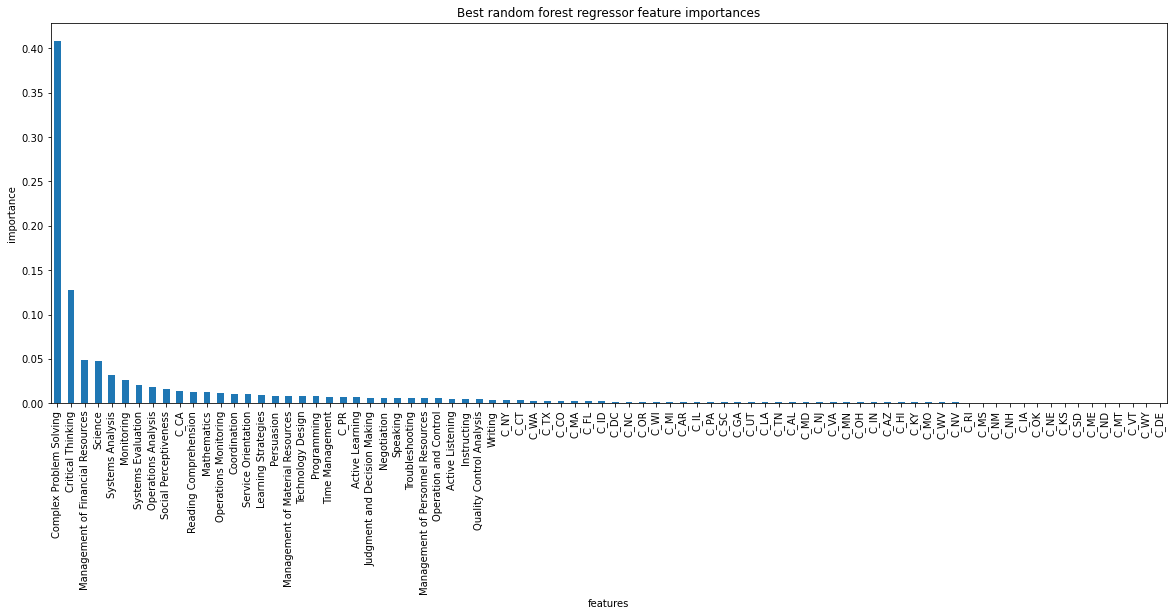

In [104]:
plt.subplots(figsize=(20, 7))
rf_feat_imps = pd.Series(coefs, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

In [105]:
# Pipeline: Standardize, Random Forest Model
pipe_rff = make_pipeline(
    MinMaxScaler(),
    RandomForestRegressor(n_estimators=1000, random_state=42)
)

In [106]:
# Fit pipeline. Train and test predictions.
pipe_rff.fit(X_train, y_train.values.ravel())
y_tr_ff_pred = pipe_rff.predict(X_train)
y_te_ff_pred = pipe_rff.predict(X_test)

In [107]:
# R_squared error
print('R^2 train: {}\nR^2 test: {}'.format(round(r2_score(y_train, y_tr_ff_pred), 3),
                                           round(r2_score(y_test, y_te_ff_pred), 3)))

R^2 train: 0.94
R^2 test: 0.888


In [108]:
# MAE of training data
print('MAE train: {}\nMSE test: {}'.format(round(mean_absolute_error(y_train, y_tr_ff_pred)), 
                                           round(mean_absolute_error(y_test, y_te_ff_pred))))

MAE train: 5108
MSE test: 6995


# Final model

In [109]:
best_model = rf_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

In [110]:
filename = '../models/skill_salary_model.pkl'
pickle.dump(best_model, open(filename, 'wb'))

loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.8879068135448255


In [111]:
loaded_model

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=1000, random_state=42))])

In [190]:
df = pd.read_csv('../data/processed/salary_skill_processed.csv')

In [229]:
sample = df.sample(1)
occupation = sample['occupation']
sample = sample.drop('occupation', axis=1)
X=sample1.drop('salary', axis=1)
y=sample['salary']
occupation, sample['Complex Problem Solving']

(13218    Cabinetmakers and Bench Carpenters
 Name: occupation, dtype: object,
 13218    2.88
 Name: Complex Problem Solving, dtype: float64)

In [230]:
salary_predicted = loaded_model.predict(X)
error = round(y - salary_predicted)

In [231]:
print(f'Occupation: {occupation}\nPredicted Salary: {round(salary_predicted[0])}\nError: {error}')

Occupation: 13218    Cabinetmakers and Bench Carpenters
Name: occupation, dtype: object
Predicted Salary: 42831
Error: 13218   -6741.0
Name: salary, dtype: float64


In [232]:
sample['Complex Problem Solving'] = 5
sample['Complex Problem Solving']

13218    5
Name: Complex Problem Solving, dtype: int64

In [233]:
X2=sample.drop('salary', axis=1)

In [234]:
salary_predicted2 = loaded_model.predict(X2)
error2 = round(y - salary_predicted2)
print(f'Occupation: {occupation}\nPredicted Salary: {round(salary_predicted2[0])}\nError: {error2}')

Occupation: 13218    Cabinetmakers and Bench Carpenters
Name: occupation, dtype: object
Predicted Salary: 47438
Error: 13218   -11348.0
Name: salary, dtype: float64


In [235]:
salary_predicted2-salary_predicted

array([4606.96685943])